In [30]:
# COLAB ONLY
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!unlink "/content/coopmotion"
!ln -s "/gdrive/My Drive/coopmotion/" "/content/coopmotion"
!rm -r "/content/coopmotion/dataset (1)" "/content/coopmotion/dataset" "/content/coopmotion/models"

ModuleNotFoundError: No module named 'google.colab'

In [75]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
sys.path.append('coopmotion/src') # COLAB
from matplotlib import pyplot as plt
from task.fancy import animate_with_targets, plot_trace
import numpy as np
import torch
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of task.fancy failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../src/task/fancy.py", line 5, in <module>
    from task.square import extract_tuple_from_state, e

# Learning

In [178]:
from task.dataset import generate_non_sequential_dataset, generate_randomstart_dataset, central_dataset
from task.square import static_evenly_spread_task, SegmentRun, proportional, sense_in_range
controller = proportional
N = 4
number_of_samples = 1000
eps = 0.01
dt = 0.1
max_time = 10
task = static_evenly_spread_task(N)
run = SegmentRun(task, controller=controller, sensor=sense_in_range(6), dt=dt)
train_dataset = central_dataset(generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=eps))
test_dataset = central_dataset(generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=eps))

KeyboardInterrupt: 

# Centralized Network

In [150]:
from keras_network import CentralizedNet
net = CentralizedNet(4)
history = net.train(epochs=100, train_dataset=train_dataset, test_dataset=test_dataset)

Input size: 12
(10342, 12) (10342, 8)
Training progress: 19.0%

KeyboardInterrupt: 

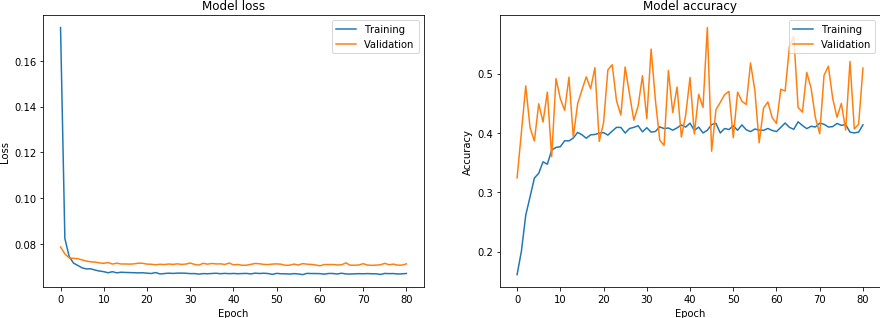

Saved in images/training/eps=0.01_N=4_n=100_net=CentralizedNet_s=in_range-6_t=StaticPositionTask.png


<Figure size 432x288 with 0 Axes>

In [62]:
from task.fancy import training_plot
training_plot(history, context=globals())

Saved in images/trace/eps=0.01_N=4_n=100_net=CentralizedNet_s=in_range-6_t=StaticPositionTask.png


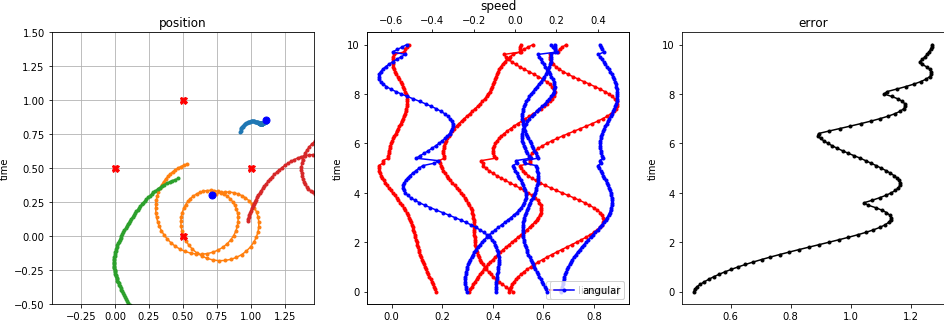

In [67]:
from task import Run
from task.square import dynamic, sense_in_range
net_controller = net.controller()
net_run = Run(task, dynamic=dynamic(dt=0.1), sensor=run.sensor, dt=0.1, controller=net_controller)
trace = net_run(T=max_time, epsilon=eps)
plot_trace(trace, task, context=globals())

In [64]:
animate_with_targets(trace, sensor=net_run.sensor, context=globals())

Saved in videos/eps=0.01_N=4_n=100_net=CentralizedNet_s=in_range-6_t=StaticPositionTask.mp4


### How well are we controlling the agents?

In [65]:
from task.dataset import generate_sequential_dataset
exact_traces = generate_sequential_dataset(run, number=100, duration=10, epsilon=0.01)
net_traces = generate_sequential_dataset(net_run, number=100, duration=10, epsilon=0.01)
from task import prepare
exact_traces = [prepare(t, padding=True, steps=50) for t in exact_traces]
net_traces = [prepare(t, padding=True, steps=50) for t in net_traces]
time = exact_traces[0].time
exact_error = np.array([t.error for t in exact_traces])
net_error = np.array([t.error for t in net_traces])

Saved in images/error/eps=0.01_N=4_n=100_net=CentralizedNet_s=in_range-6_t=StaticPositionTask.png


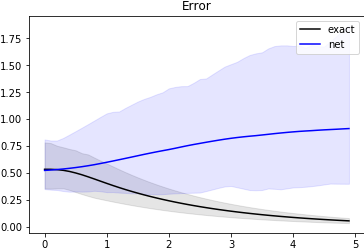

In [66]:
from task.fancy import plot_error
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, context=globals(), color='blue', label='net')

## Distributed Network

In [ ]:
from task.square import SegmentRun, dynamic_evenly_spread_task, sense_in_range, sense_all
from task.dataset import distributed_dataset
N = 4
number_of_samples = 1000
EPS = 0.001
dt = 0.1
task = dynamic_evenly_spread_task(N)
#generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=0.00001)
run = SegmentRun(task, controller=controller, sensor=sense_all(), dt=dt)
d_train_dataset = distributed_dataset(generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=EPS))
d_test_dataset = distributed_dataset(generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=EPS))
#d_train_dataset = distributed_dataset(generate_randomstart_dataset(run=run, number=number_of_samples))
#d_test_dataset = distributed_dataset(generate_randomstart_dataset(run=run, number=number_of_samples))

(568920, 6) (568920, 2)


In [ ]:
d_train_dataset[0][0],d_train_dataset[1][0]

In [ ]:
from keras_network import DistributedNet
d_net = DistributedNet((N-1)*2)
history = d_net.train(epochs=100, train_dataset=d_train_dataset, test_dataset=d_test_dataset);

In [ ]:
d_net_controller = d_net.controller()
d_net_run = Run(task, dynamic=dynamic(dt=0.1), sensor=sense_all(), dt=0.1, controller=d_net_controller)
trace = d_net_run(T=5, epsilon=0.01)
plot_trace(trace, task)

In [ ]:
animate_with_targets(trace, sensor=net_run.sensor)

In [ ]:
d_net_traces = generate_sequential_dataset(d_net_run, number=100, duration=10, epsilon=0.01)
d_net_traces = [prepare(t, padding=True, steps=50) for t in d_net_traces]
d_net_error = np.array([t.error for t in d_net_traces])

In [ ]:
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plot_error(time, d_net_error, color='green', label='d_net')
plt.legend()
plt.title('Error');

## Distributed Communicating Network

In [ ]:
from task.dataset import sequence_dataset
from task.square import smart_static_evenly_spread_task, sense_in_range, SegmentRun, proportional, static_zipf_task

In [ ]:
number_of_samples = 10
run = SegmentRun(smart_static_evenly_spread_task(4), controller=controller, sensor=sense_in_range(0.8), dt=0.1)
train_traces = generate_sequential_dataset(run=run, number=number_of_samples)
test_traces = generate_sequential_dataset(run=run, number=number_of_samples)

In [ ]:
c_train_dataset = sequence_dataset(train_traces, steps=2)
c_test_dataset = sequence_dataset(test_traces, steps=2)
c_train_dataset[50]

In [ ]:
from com_network import ComNet

In [ ]:
c_net = ComNet(N=N, broadcast=2)
c_training_loss, c_testing_loss = [], []

In [ ]:
train_net(epochs=100, net=c_net, train_dataset=c_train_dataset, test_dataset=c_test_dataset, batch_size=100, 
          training_loss=c_training_loss, testing_loss=c_testing_loss);

In [ ]:
plt.title('Loss')
plt.semilogy(c_training_loss, label='training')
plt.semilogy(c_testing_loss, label='testing')
plt.xlabel('epoch')
plt.legend()

In [ ]:
c_net_controller = c_net.controller()
c_net_run = Run(task, dynamic=dynamic(dt=0.1), sensor=run.sensor, dt=0.1, controller=c_net_controller)

In [ ]:
trace = c_net_run(T=5)
plot_trace(trace,task)

In [ ]:
animate_with_targets(trace, sensor=net_run.sensor)

In [ ]:
plt.plot(trace.control[:,:,0], trace.communication[:,0,:], '.')

In [ ]:
c_net_traces = generate_sequential_dataset(c_net_run, number=100, duration=5, epsilon=0.01)

In [ ]:
c_net_traces = [prepare(t, padding=True, steps=50) for t in c_net_traces]

In [ ]:
c_net_error = np.array([t.error for t in c_net_traces])

In [ ]:
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plot_error(time, d_net_error, color='green', label='d_net')
plot_error(time, c_net_error, color='orange', label='c_net')
plt.legend()
plt.title('Error');